# パラメータ化された量子回路の訓練

このセクションでは、勾配情報を使った手法を使用して量子回路ベースのモデルを訓練する方法を詳しく見ていきます。これらのモデルの制約と、どのように克服するのかを見ていきます。

## はじめに

古典モデルと同様に、パラメーター化された量子回路モデルを訓練して、データ駆動型のタスクを実行できます。データから任意の関数を学習するタスクは、数学的にはパラメーターベクトル $\class{theta_vec}{\vec\theta}$ に関して、[コスト](gloss:cost)または損失関数 $f(\class{theta_vec}{\vec\theta})$ (目的関数としても知られています)の最小化として表されます。一般に、パラメーター化された量子回路モデルを訓練する場合、最小化しようとしている関数は[期待値](gloss:expectation-value)です： $\class{_bra_psi_theta}{\langle \Psi(\vec\theta) |} \class{h_hat}{\hat{H}}\class{ket_psi_theta}{| \Psi(\vec\theta) \rangle}$

![「パラメーター(theta)の更新」と「計算(状態Phi(theta)におけるHの期待値)」間のサイクルを示す画像。計算値は、「パラメーターの更新」ステップにフィードバックされます。](images/training/training.svg)

変分回路 $\class{u_theta}{\mathbf{U_\theta}}$ のパラメーターを最適化するために使用できるアルゴリズムにはさまざまな種類があります（勾配ベース、進化的、および勾配のない方法）。このコースでは、勾配情報を用いた手法について説明します。

## 勾配

関数 $f(\class{theta_vec}{\vec\theta})$ があり、初期点から開始して関数の勾配 $\vec{\nabla} f(\vec\theta)$ にアクセスできる場合、関数を最小化する最も簡単な方法は、関数の最急降下 $\vec\theta_{n+1} = \vec\theta_n - \class{eta}{\eta}\class{ del}{\vec{\nabla}} f(\class{theta_vec}{\vec\theta})$ の方向に向かってパラメータを更新することです。ここで $\eta$ は学習率で、更新のサイズを制御する小さな正の[ハイパーパラメーター](gloss:hyperparameter)です。関数の[局所的最小値](gloss:local-minimum) $f(\class{theta_vec_star}{\vec\theta^*})$ に収束するまで、これを続けます。

![thetaに対するf(theta)のグラフ。複数のドットは、曲線の最小値を見つける勾配降下アルゴリズムのさまざまな状態を示しています。](images/training/gradient-descent.svg)

この手法は _最急降下法_ または _[バニラ](gloss:vanilla)(通常の)最急降下法_ と呼ばれます。これは単純な勾配であるため、特別なことは何もしていません。

Qiskitには、期待値の勾配を計算するためのさまざまな方法が用意されています。調べてみましょう。

まず、パラメーター化された状態 $\class{ket_psi_theta}{|\Psi(\vec\theta)\rangle} = \class{u_theta}{U(\vec\theta)}|00\dots 0\rangle$ を定義する必要があります。このページでは、 $\class{u_theta}{U(\vec\theta)}$ は2量子ビット上の[`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html)回路を定義しています。

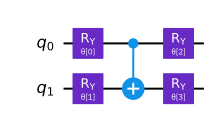

In [1]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw()

次に、[ハミルトニアン](gloss:hamiltonian)を定義する必要があります。 $\class{h_hat}{\hat H} = \class{z_hat}{\hat Z} \class{kronecker_product}{\bigotimes} \class{z_hat}{\hat Z}$ を利用します。

In [2]:
from qiskit.opflow import Z, I
hamiltonian = Z ^ Z

これらを組み合わせて期待値 $\class{_bra_psi_theta}{\langle \Psi(\vec\theta) |} \class{h_hat}{\hat{H}} \class{ket_psi_theta}{| \Psi(\vec\theta) \rangle}$ を計算します。

In [3]:
from qiskit.opflow import StateFn, PauliExpectation
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

次に、期待値の測定をシミュレートする関数を記述します。

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    # pylint: disable=missing-function-docstring
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)

具体的にするために、点 $\vec p$ とインデックス $i$ を固定してみましょう。このとき点 $\vec p$ におけるパラメーター $\theta_i$ に関する期待値の[導関数](gloss:derivative)は何でしょう。

$$
    \class{partial_derivative}{\frac{\partial}{\partial \theta_i}} \class{_bra_psi_theta}{\langle \Psi(\vec\theta) |} \class{h_hat}{\hat H} \class{ket_psi_theta}{| \Psi(\vec\theta) \rangle} \class{evaluate}{\bigg\vert_{\vec\theta = \vec p}}
$$

ランダムな点 $\vec p$ とインデックス $i=2$ を選択します（0からカウントすることを忘れないでください）。

In [5]:
import numpy as np
point = np.random.random(ansatz.num_parameters)
INDEX = 2

### 有限差分勾配

おそらく、勾配を近似する最も簡単な方法は、有限差分を利用することです。これは、おそらく非常に複雑であろう関数の内部構造とは独立して計算することが出来ます。

![グラフは曲線を示し、曲線上の3カ所に点があります。点は、eplisonによってx軸に沿って等間隔に配置されています。](images/training/finite-difference.svg)

もし $f(\vec \theta)$ での勾配の推定に興味があれば、小さな距離 $\epsilon$ を選択して、 $f(\vec \theta+\epsilon)$ と $f(\vec \theta-\epsilon)$ を計算し、2つの関数の値の差を距離で割ります： $\vec{\nabla} f(\vec \theta) \approx \frac{1}{2\epsilon}\left(f(\vec \theta+\epsilon) - f(\vec \theta-\epsilon) \right)$ 。

In [6]:
EPS = 0.2
# make identity vector with a 1 at index ``INDEX``, otherwise 0
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

0.0225830078125


これを手動で行う代わりに、Qiskitの[`Gradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html)クラスを使用できます。

In [7]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


-0.0213623046875

有限差分勾配は、ノイズの多い関数では不安定になる可能性があり、勾配に正確な式を使用するとより安定する可能性があります。このことは上で確認することができます。2つの計算は同じ式を使用していますが、ショットノイズのために異なる結果が得られています。下の例の画像では、「ノイズの多い有限差分勾配」が実際には真の勾配の反対方向を指していることがわかります。

![ノイズの多い関数、関数の真の(平均)勾配、および有限差分法から誤って計算された勾配を示す画像](images/training/noisy-gradient.svg)

### 解析的勾配

分析勾配は、勾配の分析式を評価します。一般に、手動で計算する必要があるため、これはかなり困難ですが、回路ベースの勾配については、参考文献 1 に、勾配を計算するための簡単な式を与える優れた理論的結果が紹介されています:これは、*パラメータ シフト*ルールです。

このルールでは、係数を含まずパウリ回転のみで構成される単純な回路の場合、解析勾配が次のように計算されることを示しています。

![簡略化されたパラメーターシフト方程式の画像](images/training/parameter-shift.svg)

これは、有限差分勾配の式と非常によく似ています。

手計算してみましょう。

In [8]:
EPS = np.pi / 2
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

0.015625


そしてQiskitの[`Gradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html)クラスを使用します。

In [9]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
sampler.convert(grad, value_dict).eval().real

0.0087890625

計算された解析勾配は、計算された有限差分勾配とかなり類似していることがわかります。

それでは勾配計算を理解できたところで、期待値の最適化に移りましょう。

まず、再現性の観点から初期点を固定します。

In [10]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

期待値を評価する関数と同様に、勾配を評価する関数が必要になります。

In [11]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(theta):
    # pylint: disable=missing-function-docstring
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

オプティマイザーの[収束](gloss:convergence)を比較するために、コールバック関数を使用して各ステップでの損失を追跡できます。

![ページ上部からの画像（「パラメーターの更新」/「期待値の計算」サイクル）で、左側に2つの矢印が上下を向いています。矢印には、それぞれ「callback」と「information」のラベルが付いています。](images/training/callback.svg)

In [12]:
class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

from qiskit.algorithms.optimizers import GradientDescent
gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_log.update)

そして最適化を開始し、損失をプロットします！

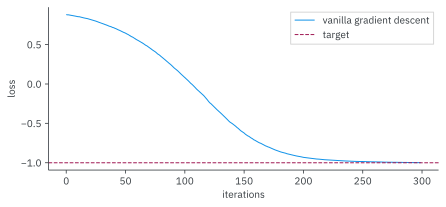

In [13]:
result = gd.minimize(
    fun=evaluate_expectation,  # function to minimize
    x0=initial_point,          # initial point
    jac=evaluate_gradient      # function to evaluate gradient
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

### 自然勾配

上記の例では、勾配降下法を使用して関数の最小値を見つけることができることがわかります。ただし、勾配降下法が常に最適な戦略であるとは限りません。

![2つの画像、左側の画像は円形の等値線で、勾配降下アルゴリズムのパスは最小値を見つけることを示しています。右側の等値線は水平方向に押しつぶされており、勾配降下アルゴリズムのパスが数回最小値をオーバーシュートしていることが示されています。](images/training/gradient-fail.png)

たとえば、左側の図を見ると、[損失ランドスケープ](gloss:loss-landscape)の端にある初期点 $\theta_0 = (x_0,y_0)$ と学習率 $\eta$ が与えられると、中心の最小値に近づくことができます。

しかし、損失状況が $x$ 次元で押しつぶされている右側の図を見ると、同じ初期点と学習率を使用しても、最小値を見つけることができないことがわかります。これは、損失の状況が各パラメーターに関して同じ割合で変化すると誤って想定しているためです。どちらのモデルも、$(x_0, y_0)、(x_1, y_1)$ の間で同じ[ユークリッド距離](gloss:euclidean-distance)を示していますが、モデル B ではこのメトリックが相対的な感度を捉えることができないため、これは不十分です。

自然勾配の考え方は、モデルの感度を考慮して $\theta_{n}$ から $\theta_{n+1}$ の決定の仕方を変更することにあります。通常の勾配ではユークリッド距離を使用しました： $d = \class{euclidean_distance}{\lVert\vec\theta_{n+1}-\vec\theta_n\rVert_2}$ 、しかしこれは損失の等値線を考慮に入れていないことがわかりました。自然勾配では、代わりにモデルに依存した距離 $d = \lVert\langle \Psi(\vec\theta_n) | \Psi(\vec\theta_{n+1}) \rangle \rVert^2$ を使用します。

![2つの画像。左側の画像は円形の等値線で、1つは等値線の2点間に線が引かれています。 1つの点は等値線の端の近くにあり、もう1つの点は中央の最小値の近くにあります。右側の等値線水平に押しつぶされていますが、等値線の2点間に線が引かれています。 1つの点は等値線の端の近くにあり、もう1つの点は中央の最小値の近くにあります。](images/training/distance.png)

![](images/training/qfi.svg)

この指標は、 *量子フィッシャー情報量* $g_{ij}(\vec\theta)$ と呼ばれ、ユークリッドパラメーター空間における最急降下をモデル空間における最急降下に変換します。これは*量子自然勾配*と呼ばれ、参考文献2で紹介されています。ここで $\vec\theta_{n+1} = \vec\theta_n-\eta \class{}{g^{-1}}(\vec\theta_n)\vec{\nabla} f(\theta_n)$ です。

![2つの画像、左側の画像は円形の等値線で、再急降下アルゴリズムのパスは最小値を見つけることを示しています。右側の等値線は水平方向に押しつぶされており、再急降下アルゴリズムのパスが示されています。各ステップも水平方向に押しつぶされており、パスが最小値を見つけることができます。](images/training/natural-gradients.png)

Qiskitでは[`Gradient`](https://qiskit.org/documentation/stubs/qiskit.opflow.gradients.Gradient.html)の代わりに[`NaturalGradient`](https://qiskit.org/documentation/stubs/qiskit.opflow.gradients.NaturalGradient.html)を使用して自然勾配を評価できます。

In [14]:
from qiskit.opflow import NaturalGradient

勾配を計算する関数と同様に、自然勾配を評価する関数を記述できるようになりました。

In [15]:
natural_gradient = (NaturalGradient(regularization='ridge')
                    .convert(expectation))
natural_gradient_in_pauli_basis = PauliExpectation().convert(
                                                    natural_gradient)
sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(theta):
    # pylint: disable=missing-function-docstring
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(natural_gradient, params=value_dict).eval()
    return np.real(result)

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.7158704  -0.86457346 -0.98086467 -0.33820315]


確かに異なる値です！

これが収束にどのように影響するかを見てみましょう。

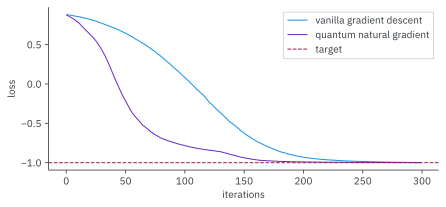

In [16]:
qng_log = OptimizerLog()
qng = GradientDescent(maxiter=300,
                      learning_rate=0.01,
                      callback=qng_log.update)

result = qng.minimize(evaluate_expectation,
                      initial_point,
                      evaluate_natural_gradient)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

これは素晴らしいですね！量子自然勾配は、通常の勾配降下よりも速くターゲットに近づくことがわかります。ただし、これには、さらに多くの量子回路を評価する必要があるという代償が伴います。

![y軸に「反復ごとの評価」、x軸に「anstazのパラメーター数」が示されたグラフ。 2本の線がプロットされ、1本は「自然勾配」のラベルが、もう一方は「通常の勾配」のラベルが付与されています。通常の勾配の線はグラフ上の全ての点で自然勾配よりも低く、増加率も低いです。](images/training/gradient-cost-no-spsa.svg)

### 同時摂動確率近似

関数 $f(\vec\theta)$ をベクトルとして見て、勾配 $\vec{\nabla} f(\vec\theta)$ を評価する場合は、 $f(\vec\theta)$ の偏導関数を各パラメーターに関して計算する必要があります。つまり勾配を計算するには、 $N$ パラメーターに対して $2N$ 回の関数評価が必要になります。

![](images/training/spsa.svg)

同時[摂動](gloss:perturbation)[確率](gloss:stochastic)近似（SPSA）は、評価の数を減らすために、勾配からランダムにサンプリングする最適化手法です。正確な値は気にせず収束のみに気を払うので、偏りのないサンプリングは平均して同じようにうまく機能するはずです。

実際には、正確な勾配は最小値まで滑らかな収束パスをたどる一方で、SPSAはランダムサンプリングのため収束パスはジャンプします。しかし勾配と同じ境界条件が与えられると収束します。

では、どのように機能するのでしょうか？ Qiskitでは[`SPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html)アルゴリズムを使用します。

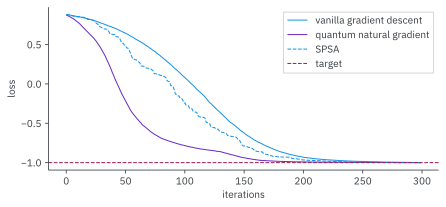

In [17]:
from qiskit.algorithms.optimizers import SPSA
spsa_log = OptimizerLog()
spsa = SPSA(maxiter=300, learning_rate=0.01,
            perturbation=0.01, callback=spsa_log.update)

result = spsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

SPSAは基本的に最急降下曲線に従い、わずかなコストで実行できることがわかります。

参考文献3で説明されているように、自然勾配についても同じことができます。ここでは詳細をスキップしますが、勾配だけでなく、量子フィッシャー情報量からサンプリングするよう拡張することで、自然勾配に対しても実行可能です。

Qiskitでは[`QNSPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html)アルゴリズムとして実装しています。パフォーマンスを比較してみましょう。

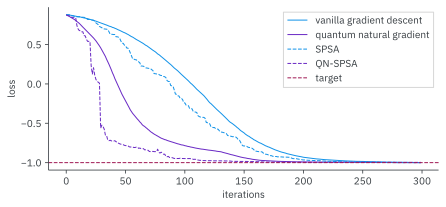

In [18]:
from qiskit.algorithms.optimizers import QNSPSA
qnspsa_log = OptimizerLog()
fidelity = QNSPSA.get_fidelity(ansatz,
                               quantum_instance,
                               expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01,
                                       perturbation=0.01,
                                       callback=qnspsa_log.update)

result = qnspsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

QNSPSAは自然勾配降下曲線にいくらか従うことがわかります。

![y軸に「反復ごとの評価」、x軸に「anstazのパラメーター数」のグラフ。 2本の実線がプロットされ、1本は「natural gradient(自然勾配)」、もう一方は「vanilla gradient(通常の勾配)」とラベルが付けられています。通常の勾配の線は全点において自然勾配よりも低い位置にあり、増加速度も遅いです。また、2本の水平な点線がプロットされています。高い位置の水平線は「QN-SPSA」とラベルされていて、「natural gradient」のすぐ上でy軸と交差しています。低い位置の点線は「SPSA」とラベルされていて「vanilla gradient」の線のすぐ上で交差しています。](images/training/gradient-costs.svg)

通常の勾配と自然勾配のコストは、パラメーターの数に関して[線形](gloss:linear-and-quadratic)かつ[2 次](gloss:linear-and-quadratic)ですが、SPSA と QNSPSA のコストは一定です。つまり、パラメーターの数に依存しません。 SPSA と QNSPSA のコストの間にはわずかなオフセットがあります。これは、自然勾配を近似するためにより多くの評価が必要になるためです。

<!-- ::: q-block.exercise -->

### クイッククイズ

    q-carousel
        q-quiz(goal="qml-training-quizousel-0")
            .question.md _Gradient_ を使った訓練の手法は...
            .option(x) 損失関数の勾配を使って回路のパラメーターを更新する
            .option 損失関数の量子自然勾配を使ってパラメーターを更新する
            .option ランダムサンプリングから計算された損失関数の近似勾配を使って回路のパラメーターを更新する
            .option ランダムサンプリングから計算された損失関数の近似量子自然勾配を使って回路のパラメーターを更新する

        q-quiz(goal="qml-training-quizousel-1")
            .question.md _Natural Gradient_ を使った訓練の手法は...
            .option 損失関数の勾配を使って回路のパラメーターを更新する
            .option(x) 損失関数の量子自然勾配を使ってパラメーターを更新する
            .option ランダムサンプリングから計算された損失関数の近似勾配を使って回路のパラメーターを更新する
            .option ランダムサンプリングから計算された損失関数の近似量子自然勾配を使って回路のパラメーターを更新する

        q-quiz(goal="qml-training-quizousel-2")
            .question.md _SPSA_ を使った訓練の手法は...
            .option 損失関数の勾配を使って回路のパラメーターを更新する
            .option 損失関数の量子自然勾配を使ってパラメーターを更新する
            .option(x) ランダムサンプリングから計算された損失関数の近似勾配を使って回路のパラメーターを更新する
            .option ランダムサンプリングから計算された損失関数の近似量子自然勾配を使って回路のパラメーターを更新する

        q-quiz(goal="qml-training-quizousel-3")
            .question.md _QNSPSA_ を使った訓練の手法は...
            .option 損失関数の勾配を使って回路のパラメーターを更新する
            .option 損失関数の量子自然勾配を使ってパラメーターを更新する
            .option ランダムサンプリングから計算された損失関数の近似勾配を使って回路のパラメーターを更新する
            .option(x) ランダムサンプリングから計算された損失関数の近似量子自然勾配を使って回路のパラメーターを更新する

<!-- ::: -->

### 実際の訓練

近い将来の量子コンピューティングの時代では、回路の評価はコストが高くつき、デバイスのノイズの性質のために読み出しは完全ではありません。したがって実際には、SPSAがしばしば使われます。収束を改善するために、一定の学習率ではなく、指数関数的に減少する学習率を使用します。次の図は、一定の学習率（点線）と指数関数的に減少する学習率（実線）の典型的な収束を示しています。一定の学習率の収束は滑らかな減少線であるのに対し、指数関数的に減少する学習率の収束はより急で、よりふらついていることがわかります。これは、損失関数の振舞いを知っている場合にうまく機能します。

<!-- vale QiskitTextbook.Spelling = NO -->

![y軸に損失、x軸に反復を示したグラフ。グラフAの底の方には「target」とラベルされた緑の水平な線があります。「fixed eta」とラベルされた点曲線はy軸の高いところから「target」の線に向かって緩やかに落ちています。一方で「powerlaw eta」とラベルされたノイズの多い曲線は始点は「fixed eta」と同じy軸の高いところにあるものの、「target」の線に向かってより速く落ちています。](https://github.com/Qiskit/platypus/blob/main/translations/ja/quantum-machine-learning/images/training/learning-rate-0.svg?raw=true)

![y軸に学習率(eta)、x軸に反復を示したグラフ。y軸の30%付近には「eta = const」とラベルされた緑の水平な点線があります。「eta proportional to alpha^n」とラベルされた点曲線はy軸の高いところから始まり、緩やかに落ちて「eta = const」を通り過ぎています…](images/training/learning-rate-1.svg)

Qiskitでは学習率を指定しない場合、モデルに合わせて学習率を自動的に調整しようとします。

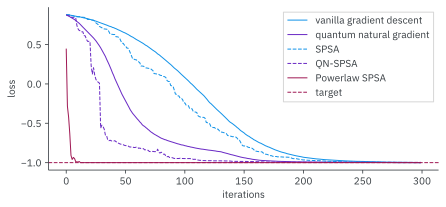

In [19]:
autospsa_log = OptimizerLog()
autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_log.update)

result = autospsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_log.loss, 'C3', label='Power-law SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

小さなモデルにおいては、この方法が最もよく機能することがわかります。より大きなモデルの場合、収束の様子はおそらく自然勾配のようになります。

## 制約

勾配を使用した訓練は、小さなサンプルモデルでうまく機能することを確認しました。しかし、量子ビットの数を増やしても同じことが期待できるでしょうか？これを調査するために、さまざまなモデルサイズに対して勾配の[分散](gloss:variance)を測定します。考え方は単純です。分散が非常に小さい場合、パラメーターを更新するための十分な情報がないということになります。

### 指数関数的な勾配消失（不毛な台地）

標準的なパラメーター化された量子回路（ [`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) ）を選び、量子ビットと層の数を増やす、つまり回路の幅と深さを増やして勾配を計算するとどうなるかを見てみましょう。

![n量子ビット回路の画像。 RY(theta_n)は各量子ビットに作用し、その後にいくつかのCNOTとより多くのRYゲート(異なるパラメーター)が続きます。 CNOTおよびその他のRYゲートは「n」回繰り返されます。](images/training/bpcircuit.svg)

In [20]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and
    ``reps`` repetitions.

    We sample 100 times for random parameters and compute the gradient
    of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits

    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator,
                          is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation,
                              params=ansatz.parameters[index])

    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())

    return grads

2量子ビットから12量子ビットまでプロットしてみましょう。

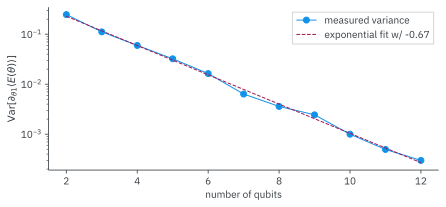

In [21]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]

fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='measured variance')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

なんと！分散は指数関数的に減少します！これは勾配に含まれる情報がますます少なくなり、モデルの訓練が困難になっていることを意味します。これは「[不毛な台地](gloss:barren-plateau)問題」または「指数関数的な勾配消失」として知られており、参考文献4および5で詳細に説明されています。

<!-- ::: q-block.exercise -->

### 試してみよう

自然勾配には不毛な台地があるでしょうか？ [IBM Quantum Lab](https://quantum-computing.ibm.com/lab)で、普通の勾配ではなく、自然勾配に対して上記のような不毛な台地を作成してみてください。勾配の代わりに自然勾配を計算する新しい関数`sample_natural_gradients`を作成する必要があります。

<!-- ::: -->

これらの不毛な台地について私たちにできることはあるでしょうか？これは現在の研究のホットトピックであり、不毛な台地を緩和するためのいくつかの提案があります。

グローバルおよびローカルのコスト関数とansatzの深さが不毛な台地にどのように影響するかを見てみましょう。最初に、[グローバル演算子](gloss:global-operator)を使用した短い深さの単層回路を見ていきます。

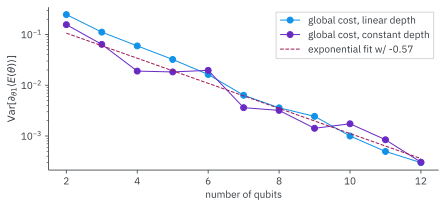

In [22]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]

fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients,
                                           axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-',
             label='global cost, constant depth')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

グローバル演算子による短い深さの単層回路は、依然として不毛な台地問題を引き起こしていることがわかります。

ローカル演算子を使用するとどうなるでしょうか？

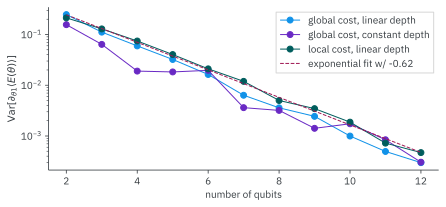

In [23]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n,
                                        local=True) for n in num_qubits]
fit = np.polyfit(num_qubits,
                 np.log(np.var(linear_depth_local_gradients,axis=1)),
                 deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1),
             'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1),
             'o-', label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

ローカル演算子を用いた回路も不毛な高原台地が発生しています。

短い深さ、単層、ローカル演算子を用いた回路はどうでしょうか？

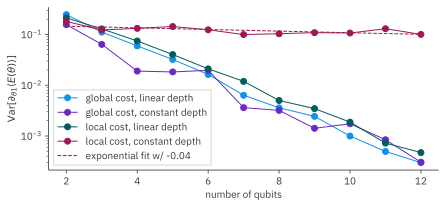

In [24]:
num_qubits = list(range(2, 13))
fixed_depth_local_gradients = [sample_gradients(n, 1,
                                        local=True) for n in num_qubits]

fit = np.polyfit(num_qubits,
                 np.log(np.var(fixed_depth_local_gradients, axis=1)),
                 deg=1)

x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1),
             'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1),
             'o-', label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1),
             'o-', label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

ローカル演算子を用いた一定の深さの回路勾配の分散は消失しない、つまり、不毛な台地問題は起きないことがわかります。ただし、これらの回路は通常シミュレートが容易であるため、従来のモデルに勝る点はありません。

<!-- ::: q-block.exercise -->

### クイッククイズ

<!-- ::: q-quiz(goal="qml-training-1") -->

<!-- ::: .question -->

勾配の分散は、どのタイプの回路で消えないでしょう？

<!-- ::: -->

<!-- ::: .option -->

1. グローバル演算子、線形な深さ

<!-- ::: -->

<!-- ::: .option -->

1. グローバル演算子、一定の深さ

<!-- ::: -->

<!-- ::: .option -->

1. ローカル演算子、線形な深さ

<!-- ::: -->

<!-- ::: .option(correct) -->

1. ローカル演算子、一定の深さ

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

これは、層ごとのトレーニングのインスピレーションです。ここでは、量子的な利点を提供しない可能性がある基本的な回路から始め、ローカル 演算子を使用して1層の回転を行います。これらのパラメーターを最適化して修正し、次のステップでローカル演算子を使用して回転の 2 番目の層を追加し、それらを最適化して修正し、必要な数の層について続行します。これにより、各最適化ステップでローカル 演算子を使用した一定の深さの回路のみが使用されるため、不毛の台地が回避される可能性があります。

![3つの反復のそれぞれに1つずつ、3つの3量子ビット回路があります。最初の回路では、パラメーター化されたゲートの層が1つだけあり、反復1でトレーニングします。後続の各反復では、パラメーター化されたゲートが徐々に追加され、これらの新しいゲートのみが訓練されます。](images/training/layertraining.svg)

これは、次の方法でQiskitに実装できます。

In [25]:
NUM_QUBITS = 6
OPERATOR = Z ^ Z ^ (I ^ (NUM_QUBITS - 4))

def minimize(circuit, optimizer):
    """
    Args:
        circuit (QuantumCircuit): (Partially bound) ansatz circuit to train
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        OptimizerResult: Result of minimization
    """
    initial_point = np.random.random(circuit.num_parameters)

    exp = StateFn(OPERATOR, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)

    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(quantum_instance, caching="all")

    def loss(theta):
        values_dict = dict(zip(circuit.parameters, theta))
        return np.real(sampler.convert(exp, values_dict).eval())

    def gradient(theta):
        values_dict = dict(zip(circuit.parameters, theta))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.minimize(loss, initial_point, gradient)

def layerwise_training(ansatz, max_num_layers, optimizer):
    """
    Args:
        ansatz (QuantumCircuit): Single circuit layer to train & repeat
        max_num_layers (int): Maximum number of layers
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        float: Lowest value acheived
        list[float]: Best parameters found
    """
    optimal_parameters = []
    for reps in range(max_num_layers):
        ansatz.reps = reps

        # fix the already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        partially_bound = ansatz.bind_parameters(values_dict)

        result = minimize(partially_bound, optimizer)
        optimal_parameters += list(result.x)
        print('Layer:', reps, ' Best Value:', result.fun)

    return result.fun, optimal_parameters

ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

np.random.seed(12)  # for reproducibility
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)

Layer: 1  Best Value: 0.2421875
Layer: 2  Best Value: -0.14428710937499992
Layer: 3  Best Value: -0.513427734375


回路の深さを増やすと、損失関数が-1に向かって減少することがわかります。したがって、不毛な台地問題は見られません。

## 参考文献

1. Maria Schuld, Ville Bergholm, Christian Gogolin, Josh Izaac and Nathan Killoran, *Evaluating analytic gradients on quantum hardware*, Physical Revview A 99, 032331 (2019), [doi:10.1103/PhysRevA.99.032331](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032331), [arXiv:1811.11184](https://arxiv.org/abs/1811.11184).
2. James Stokes, Josh Izaac, Nathan Killoran and Giuseppe Carleo, *Quantum Natural Gradient*, Quantum 4, 269 (2020), [doi:10.22331/q-2020-05-25-269](https://doi.org/10.22331/q-2020-05-25-269), [arXiv:1909.02108](https://arxiv.org/abs/1909.02108).
3. Julien Gacon, Christa Zoufal, Giuseppe Carleo and Stefan Woerner, *Simultaneous Perturbation Stochastic Approximation of the Quantum Fisher Information*, [arXiv:2103.09232](https://arxiv.org/abs/2103.09232).
4. Jarrod R. McClean, Sergio Boixo, Vadim N. Smelyanskiy, Ryan Babbush and Hartmut Neven, *Barren plateaus in quantum neural network training landscapes*, Nature Communications, Volume 9, 4812 (2018), [doi:10.1038/s41467-018-07090-4](https://www.nature.com/articles/s41467-018-07090-4), [arXiv:1803.11173](https://arxiv.org/abs/1803.11173).
5. M. Cerezo, Akira Sone, Tyler Volkoff, Lukasz Cincio and Patrick J. Coles, *Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits*, Nature Communications 12, 1791 (2021), [doi:10.1038/s41467-021-21728-w](https://www.nature.com/articles/s41467-021-21728-w), [arXiv:2001.00550](https://arxiv.org/abs/2001.00550).

In [26]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table